# Linear Discriminant Analysis (LDA) algorithm  
Алгоритм уменьшения размерности, который использует информацию от нескольких признаков для создания новой оси и проецирует данные на эту новую ось таким образом, чтобы минимизировать дисперсию и максимизировать расстояние между средними двух классов.  
  
Как работает LDA?  
1. Считает среднее каждой переменной по каждому классу
2. Вычисляет $S_W$ (матрица рассеяния внутри класса) и $S_B$ (матрица рассеяния между классами)  
$S_W = \sum_{i=1}^c S_i$, с - кол-во классов  
$S_B = \sum_{i=1}^c N_i(m_i - m)(m_i - m)^T$  
$S_i = \sum_{x\in D_i}^n (x-m_i)(x - m_i)^T$  
$m_i = \frac{1}{n_i} \sum_{x\in D_i}^n x_k$, где $x$ - объект в матрице, n - кол-во объектов  
$m = \frac{1}{n} \sum_i^n x_i$
3. Вычисляет собственные значения и собственный вектор для $S_W$, $S_B$  
4. Сортирует собственные значения в порядке убывания и выбирает первые k  
5. Создает новую матрицу, содержащую собственные векторы, которые сопоставляются с k выбранными значениями  
6. Получает новые признаки, беря точечное произведение данных и матриц  
  
По своей логике он похож на PCA, однако цель PCA состоит в том, чтобы перейти к более низкоразмерному пространству, не теряя при этом важную информацию. Сохраняются признаки с наибольшей дисперсией внутри классов. Избыточные и коррелированные функции отбрасываются. Цель LDA состоит в том, чтобы различать различные классы в низкоразмерном пространстве, сохраняя компоненты, содержащие значения признаков, которые имеют наилучшее разделение между классами. Хорошо вышесказанное описывает картинка:  
<img src="lda2.png">  
В случае равномерно распределенных данных LDA почти всегда работает лучше, чем PCA. Однако, если данные неравномерно распределены, то рекомендуется использовать PCA, так как LDA может смещаться в сторону класса большинства. PCA можно применять как к размеченным, так и к неразмеченным данным, в отличие от LDA.
  
Как подготовить данные для LDA?  
* убрать выбросы  
* стандартизация входных данных таким образом, чтобы они имели среднее значение 0 и стандартное отклонение 1  
* преобразование признаков таким образом, чтобы они представляли из себя гауссово распределение

In [64]:
import numpy as np
import time
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import fetch_openml
from sklearn.datasets import load_wine
import pandas as pd
np.set_printoptions(precision=4)
import seaborn as sns
sns.set()
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


In [65]:
wine = load_wine()
X = pd.DataFrame(wine.data, columns=wine.feature_names)
y = pd.Categorical.from_codes(wine.target, wine.target_names)
df = X.join(pd.Series(y, name='class'))
print(f'X shape: {X.shape}')
print(f'Классы: {wine.target_names}')
X.head()

X shape: (178, 13)
Классы: ['class_0' 'class_1' 'class_2']


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


Приведем пример, как происходят вычисления математически, не используя реализаций на Питоне. Сначала создаем векторы средних по всем классам:

In [66]:
class_feature_means = pd.DataFrame(columns=wine.target_names)
for c, rows in df.groupby('class'):
    class_feature_means[c] = rows.mean()
class_feature_means

,class_0,class_1,class_2
alcohol,13.744746,12.278732,13.153750
malic_acid,2.010678,1.932676,3.333750
ash,2.455593,2.244789,2.437083
alcalinity_of_ash,17.037288,20.238028,21.416667
magnesium,106.338983,94.549296,99.312500
total_phenols,2.840169,2.258873,1.678750
flavanoids,2.982373,2.080845,0.781458
nonflavanoid_phenols,0.290000,0.363662,0.447500
proanthocyanins,1.899322,1.630282,1.153542
color_intensity,5.528305,3.086620,7.396250


Строим $S_W$ и $S_B$, считаем собственные вектора и значения, выбираем первые k штук

In [67]:
within_class_scatter_matrix = np.zeros((13,13))
for c, rows in df.groupby('class'):
    rows = rows.drop(['class'], axis=1)
    s = np.zeros((13,13))
    for index, row in rows.iterrows():
            x, mc = row.values.reshape(13,1), class_feature_means[c].values.reshape(13,1)
            s += (x - mc).dot((x - mc).T)
    within_class_scatter_matrix += s

feature_means = df.mean()
between_class_scatter_matrix = np.zeros((13,13))
for c in class_feature_means:    
    n = len(df.loc[df['class'] == c].index)
    
    mc, m = class_feature_means[c].values.reshape(13,1), feature_means.values.reshape(13,1)
    
    between_class_scatter_matrix += n * (mc - m).dot((mc - m).T)

In [68]:
eigen_values, eigen_vectors = np.linalg.eig(np.linalg.inv(within_class_scatter_matrix).dot(between_class_scatter_matrix))

In [69]:
pairs = [(np.abs(eigen_values[i]), eigen_vectors[:,i]) for i in range(len(eigen_values))]
pairs = sorted(pairs, key=lambda x: x[0], reverse=True)
for pair in pairs:
    print(pair[0])

9.081739435042472
4.128469045639484
8.881784197001252e-16
7.41949604398113e-16
7.41949604398113e-16
6.57104310784389e-16
6.57104310784389e-16
2.9039090283069212e-16
2.9039090283069212e-16
2.58525572226227e-16
6.126103277916086e-17
6.126103277916086e-17
4.86945776983596e-17


In [70]:
eigen_value_sums = sum(eigen_values)
print('Explained Variance')
for i, pair in enumerate(pairs):
    print('Eigenvector {}: {}'.format(i, (pair[0]/eigen_value_sums).real))

Explained Variance
Eigenvector 0: 0.6874788878860784
Eigenvector 1: 0.31252111211392164
Eigenvector 2: 6.723424698398662e-17
Eigenvector 3: 5.616486715430028e-17
Eigenvector 4: 5.616486715430028e-17
Eigenvector 5: 4.9742160522698054e-17
Eigenvector 6: 4.9742160522698054e-17
Eigenvector 7: 2.1982310366664338e-17
Eigenvector 8: 2.1982310366664338e-17
Eigenvector 9: 1.957013567229342e-17
Eigenvector 10: 4.637400906181487e-18
Eigenvector 11: 4.637400906181487e-18
Eigenvector 12: 3.686132415666904e-18


In [71]:
w_matrix = np.hstack((pairs[0][1].reshape(13,1), pairs[1][1].reshape(13,1))).real
X_lda = np.array(X.dot(w_matrix))

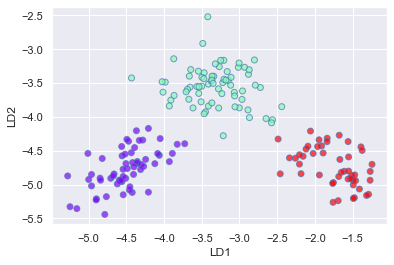

In [72]:
le = LabelEncoder()
y = le.fit_transform(df['class'])
X_lda = np.array(X.dot(w_matrix))
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.scatter(
    X_lda[:,0],
    X_lda[:,1],
    c=y,
    cmap='rainbow',
    alpha=0.7,
    edgecolors='b'
)

Теперь используем реализацию на Питоне:

In [73]:
lda = LinearDiscriminantAnalysis()
X_lda = lda.fit_transform(X, y)
lda.explained_variance_ratio_

array([0.6875, 0.3125])

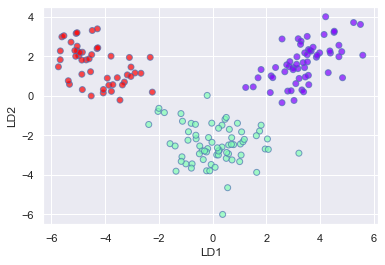

In [74]:
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.scatter(
    X_lda[:,0],
    X_lda[:,1],
    c=y,
    cmap='rainbow',
    alpha=0.7,
    edgecolors='b'
)

In [77]:
time_start = time.time()
rf_original = RandomForestClassifier(oob_score=True)
rf_original.fit(X, y)
print(f'Time elapsed for Random Forest on mnist_digits: {time.time()-time_start} seconds')
print(f'Качество Random Forest на исходных картинках: {rf_original.oob_score_}\n')

time_start = time.time()
rf_original = RandomForestClassifier(oob_score=True)
rf_original.fit(X_lda, y)
print(f'Time elapsed for Random Forest on LDA with 2 components: {time.time()-time_start} seconds')
print(f'Качество Random Forest на LDA c 2 компонентами: {rf_original.oob_score_}')
print(f'Дисперсия при 2 компонентах: {lda.explained_variance_ratio_.sum()}')

Time elapsed for Random Forest on mnist_digits: 0.3869776725769043 seconds
Качество Random Forest на исходных картинках: 0.9831460674157303

Time elapsed for Random Forest on LDA with 2 components: 0.3506510257720947 seconds
Качество Random Forest на LDA c 2 компонентами: 0.9943820224719101
Дисперсия при 2 компонентах: 1.0


Какие-то чересчур хорошие данные с простой классификацией, рассмотрим на чем-то посложнее - на наших любимых рукописных числах 

In [78]:
mnist = fetch_openml("mnist_784")
X = mnist.data / 255.0
y = mnist.target
X = X[:10000][:]
y = y[:10000]

<Figure size 432x288 with 0 Axes>

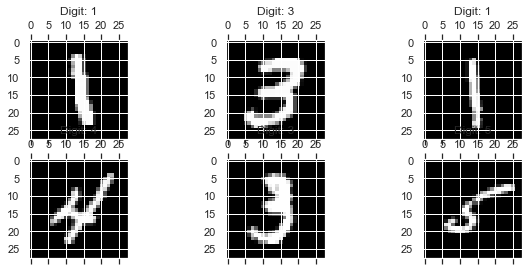

In [79]:
plt.gray()
fig = plt.figure(figsize=(10,4))
for i in range(6,12):
    ax = fig.add_subplot(2,3,i-6+1, title="Digit: {}".format(str(y[i])))
    ax.matshow(X[i][:].reshape((28, 28)))
plt.show() 

In [80]:
time_start = time.time()
rf_original = RandomForestClassifier(oob_score=True)
rf_original.fit(X, y)
print(f'Time elapsed for Random Forest on mnist_digits: {time.time()-time_start} seconds')
print(f'Качество Random Forest на исходных картинках: {rf_original.oob_score_}\n')

time_start = time.time()
lda = LinearDiscriminantAnalysis(n_components = 2)
X_lda_2 = lda.fit_transform(X, y)
lda.explained_variance_ratio_
print(f'Time elapsed for LDA with 2 components: {time.time()-time_start} seconds')
time_start = time.time()
rf_original = RandomForestClassifier(oob_score=True)
rf_original.fit(X_lda_2, y)
print(f'Time elapsed for Random Forest on LDA with 2 components: {time.time()-time_start} seconds')
print(f'Дисперсия при 2 компонентах: {lda.explained_variance_ratio_.sum()}')
print(f'Качество Random Forest на LDA с 2 компонентами: {rf_original.oob_score_}\n')

Time elapsed for Random Forest on mnist_digits: 17.678247451782227 seconds
Качество Random Forest на исходных картинках: 0.9447

Time elapsed for LDA with 2 components: 3.563655376434326 seconds
Дисперсия при 2 компонентах: 0.43611231133397477
Time elapsed for Random Forest on LDA with 2 components: 3.7650842666625977 seconds
Качество Random Forest на LDA с 2 компонентами: 0.5633



<AxesSubplot:xlabel='lda_2_x', ylabel='lda_2_y'>

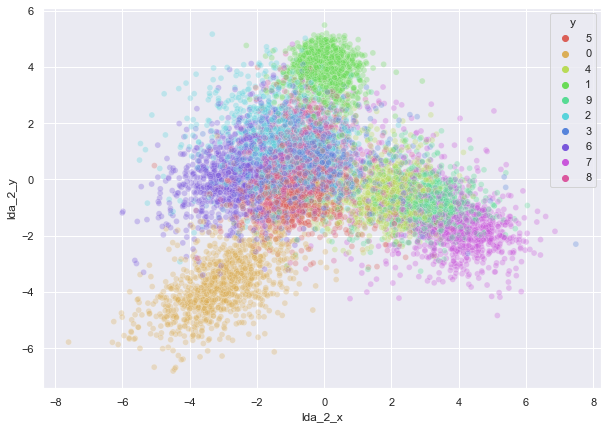

In [81]:
df = pd.DataFrame()
df['lda_2_x'] = X_lda_2[:,0]
df['lda_2_y'] = X_lda_2[:,1]
df['y'] = y
plt.figure(figsize=(10,7))
sns.scatterplot(
    x="lda_2_x", y="lda_2_y",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
    alpha=0.3
)

На двух компонентах LDA выдает не самое лучшее качество и на визуализации тоже классы плохо различимы. Увеличим кол-во компонент, чтобы получить хорошее качество на RandomForest и большую дисперсию. Максимальное количество компонент может равняться min(n_features, n_classes - 1)

In [86]:
time_start = time.time()
lda = LinearDiscriminantAnalysis(n_components = 9)
X_lda_9 = lda.fit_transform(X, y)
lda.explained_variance_ratio_
print(f'Time elapsed for LDA with 9 components: {time.time()-time_start} seconds')
time_start = time.time()
rf_original = RandomForestClassifier(oob_score=True)
rf_original.fit(X_lda_9, y)
print(f'Time elapsed for Random Forest on LDA with 9 components: {time.time()-time_start} seconds')
print(f'Дисперсия при 9 компонентах: {lda.explained_variance_ratio_.sum()}')
print(f'Качество Random Forest на LDA с 9 компонентами: {rf_original.oob_score_}\n')

Time elapsed for LDA with 9 components: 3.7823359966278076 seconds
Time elapsed for Random Forest on LDA with 9 components: 6.997626543045044 seconds
Дисперсия при 9 компонентах: 1.0
Качество Random Forest на LDA с 9 компонентами: 0.9182



In [87]:
X_lda_9.shape

(10000, 9)

Ресурсы:   
[LDA](https://towardsdatascience.com/linear-discriminant-analysis-in-python-76b8b17817c2)  
[Про плюсы, особенности LDA и его отличие от других алгоритмов](https://www.mygreatlearning.com/blog/linear-discriminant-analysis-or-lda/#assumptionsoflda)  
[Документация LDA](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html)